In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset')

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset


100%|██████████| 58.1M/58.1M [00:02<00:00, 30.3MB/s]


In [27]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob

In [5]:
import os
import shutil
import random

# Define original and target directories for blood group classification
original_folder = '/content/finger-print-based-blood-group-dataset/dataset_blood_group'  # Folder containing subdirectories for each blood group
train_dir = '/content/split/train'
test_dir = '/content/split/test'
val_dir = '/content/split/val'

# List the blood group categories (these should match the subfolder names)
blood_groups = ['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-']

# Create the necessary directories for each blood group if they don't exist
for group in blood_groups:
    os.makedirs(os.path.join(train_dir, group), exist_ok=True)
    os.makedirs(os.path.join(test_dir, group), exist_ok=True)
    os.makedirs(os.path.join(val_dir, group), exist_ok=True)

# Get subfolders (blood groups) from the original folder
grouped_files = {group: [] for group in blood_groups}

# Iterate through the subfolders and list the images for each group
for group in blood_groups:
    group_folder = os.path.join(original_folder, group)
    if os.path.isdir(group_folder):
        all_files = os.listdir(group_folder)
        for file_name in all_files:
            if file_name.lower().endswith('.bmp'):  # Ensure it's a BMP image file (case insensitive)
                grouped_files[group].append(file_name)

# Check if any files were found for each blood group
for group in blood_groups:
    print(f"Found {len(grouped_files[group])} files for {group} group")

# Shuffle the files to ensure randomness
for group in grouped_files:
    random.shuffle(grouped_files[group])

# Split into train, test, and validation sets (80/10/10 split)
def split_files(files):
    train_split = int(0.8 * len(files))
    test_split = int(0.9 * len(files))
    train_files = files[:train_split]
    test_files = files[train_split:test_split]
    val_files = files[test_split:]
    return train_files, test_files, val_files

# Split files for each blood group
train_files = {}
test_files = {}
val_files = {}

for group in blood_groups:
    train_files[group], test_files[group], val_files[group] = split_files(grouped_files[group])

# Function to copy files to the respective directories
def copy_files(file_list, target_dir, original_folder, group):
    for file_name in file_list:
        src = os.path.join(original_folder, group, file_name)  # Full path to source file
        dst = os.path.join(target_dir, group, file_name)  # Full path to destination file
        shutil.copy(src, dst)  # Copy file to destination

# Copy files into respective directories for each blood group
for group in blood_groups:
    copy_files(train_files[group], train_dir, original_folder, group)
    copy_files(test_files[group], test_dir, original_folder, group)
    copy_files(val_files[group], val_dir, original_folder, group)

print("Data successfully split!")


Found 565 files for A+ group
Found 1009 files for A- group
Found 652 files for B+ group
Found 741 files for B- group
Found 708 files for AB+ group
Found 761 files for AB- group
Found 852 files for O+ group
Found 712 files for O- group
Data successfully split!


In [6]:
# Set up image generators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [8]:
# Specify directories containing training and validation data
train_dir = '/content/split/train'
val_dir = '/content/split/val'


In [9]:
# Load the training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

Found 4796 images belonging to 8 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 605 images belonging to 8 classes.


In [20]:
# Load Pre-trained ResNet50 Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [21]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [22]:
# useful for getting number of output classes
folders = glob('/content/split/train/*')
folders

['/content/split/train/O+',
 '/content/split/train/A-',
 '/content/split/train/A+',
 '/content/split/train/B+',
 '/content/split/train/AB+',
 '/content/split/train/O-',
 '/content/split/train/AB-',
 '/content/split/train/B-']

In [23]:
# our layers - you can add more if you want
x = Flatten()(model.output)

In [24]:
# out put layer
prediction = Dense(len(folders), activation='sigmoid')(x)

In [28]:
# create a model object
model = Model(inputs=model.input, outputs=prediction)

In [29]:
# here is the structure of the model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,390,536 (93.04 MB)

 Trainable params: 24,337,416 (92.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [32]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 695ms/step - accuracy: 0.2396 - loss: 6.2155 - val_accuracy: 0.1091 - val_loss: 7.6208
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 75s 461ms/step - accuracy: 0.3924 - loss: 1.6512 - val_accuracy: 0.1240 - val_loss: 2.2423
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 457ms/step - accuracy: 0.4420 - loss: 1.4379 - val_accuracy: 0.1240 - val_loss: 2.7456
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 459ms/step - accuracy: 0.5610 - loss: 1.1627 - val_accuracy: 0.2099 - val_loss: 5.9158
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 73s 459ms/step - accuracy: 0.6379 - loss: 0.9621 - val_accuracy: 0.1554 - val_loss: 9.1223
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 461ms/step - accuracy: 0.6724 - loss: 0.8443 - val_accuracy: 0.2099 - val_loss: 5.0174
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 459ms/step - accuracy: 0.6753 - loss: 0.8507 - val_accuracy: 0.5322 - val_loss: 1.6994
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 457ms/step - accuracy: 0.7147 - loss: 0.7688 - va

In [34]:
import matplotlib.pyplot as plt

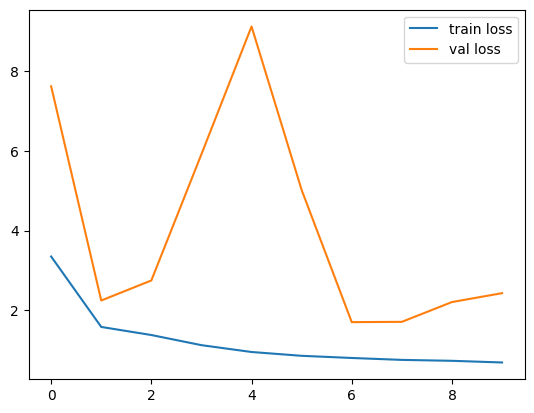

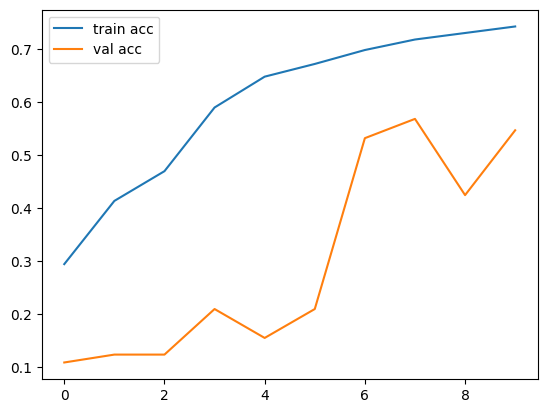

<Figure size 640x480 with 0 Axes>

In [36]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [37]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Assuming `model` is your trained model
# and it outputs class probabilities for multi-class classification

def blood_groups(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Assuming the model was trained on 224x224 images
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Normalize the image (if required)
    img_array = img_array / 255.0  # Normalize if the model expects input between 0 and 1

    # Make predictions
    predictions = model.predict(img_array)

    # Get predicted class (index of the highest probability)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map the predicted class index to plant disease type
    class_labels=['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-']

    # Get the plant disease type based on predicted class
    plant_disease_type = class_labels[predicted_class]

    print(f"Predicted : {plant_disease_type}")

    # Display the image with the predicted class label
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Plant Disease Type: {plant_disease_type}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted : AB-


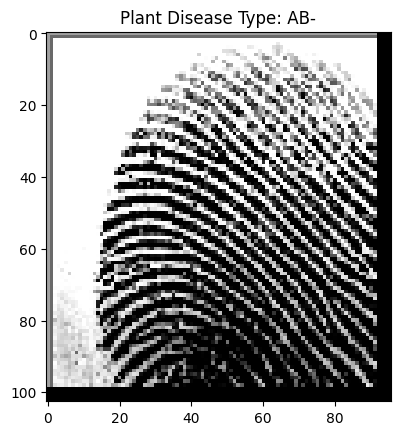

In [41]:
blood_groups('/content/split/test/B-/cluster_3_1018.BMP')

In [42]:
# Save model architecture to JSON format
model_json = model.to_json()  # This works with both Sequential and Functional API
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model architecture to YAML format
# Using the JSON format as a workaround since direct YAML support is not available for Functional models
with open("model_architecture.yaml", "w") as yaml_file:
    yaml_file.write(model_json)  # Save the JSON architecture in a YAML file

# Save model weights to HDF5 format
model.save_weights("model_weights.weights.h5")

print("Model architecture and weights saved successfully!")

Model architecture and weights saved successfully!


In [44]:
from google.colab import files

# Download the files to your local system
files.download('model_architecture.json')
files.download('model_architecture.yaml')
files.download('/content/model_weights.weights.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>